The structure of our tutorial will go as follows (it will follow pretty closely the tutorial from Ben sorcher which goes over his paper: https://github.com/ganguli-lab/grid-pattern-formation/blob/master/inspect_model.ipynb)

- https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002553 for rat foraging 
- Show real grid cell + place cell ratemaps
- Plot simulated place cell ratemaps
- Plot simulated trajectories
- Get time-series of place cells
- Intro to RNNs
- Hardcoded RNNs that make grid cells (ila fiete paper 2009 https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1000291&type=printable): (matlab code here: https://www.dropbox.com/sh/ird9hnh8xbh76m8/AADIvXSqkUsWsVrUAoJFOU23a?e=1&dl=0, eqns from “IDEALIZED PATH INTEGRATOR MODELS” section in https://www.cell.com/neuron/pdf/S0896-6273(22)00907-2.pdf )
- Train a RNN to predict place cells (ref ben sorscher paper)(Do with when only inputting place cell for time-step 0 and none thereafter)
- Plot RNN neuron ratemaps
- Train with/without Relu and see difference in ratemaps. Ideally would have hexagonal grids in relu case (like ben sorcher sees)
- Low dimensional population analysis to see torus (Fig 4 of https://www.cell.com/neuron/pdf/S0896-6273(22)00907-2.pdf) + relate to low dimensional of real grid cells (figure from https://www.nature.com/articles/s41586-021-04268-7) as well as low dim analysis of idealised path integration model
- Eigen vals of RNN conectivity matrix and relate to idealised attractor connectivity matrices ( (Fig 5 of https://www.cell.com/neuron/pdf/S0896-6273(22)00907-2.pdf)

In [39]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import os
import pickle

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from neuralplayground.experiments import Sargolini2006Data
from neuralplayground.agents import TrajectoryGenerator, Burak2009
from neuralplayground.utils import PlaceCells
from neuralplayground.plotting import plot_trajectory_place_cells_activity
from neuralplayground.config import load_plot_config
load_plot_config()

# Show real grid cell + place cell ratemaps from sargolini and hafting

In [41]:
sargolini_data = Sargolini2006Data(verbose=True)

Dataset readme:
The sample includes conjunctive cells and head direction cells from layers III and V of medial entorhinal cortex and have  been published in 
Sargolini et al. (Science, 2006). 

The files are in matlab format. They include spike and position times for recorded cells from rats that were running in a 1 x 1 m
enclosure. The cells were recorded in the dorsocaudal 25% portion of the medial entorhinal cortex. Position is given for two LEDs 
to enable calculation of head direction.

The cell id is based on tetrode number and cell number (i.e: t2c7).

The file naming convention is as follow:

Rat number - session number _ cell id (i.e: 11084-03020501_t2c1).

Each session duration is normally 10 minutes, but some sessions are combination of 2 or more 10 minutes sessions, this is marked in 
the file name by using "+" between the session numbers (i.e: 11207-21060501+02_t6c1). Note that the 6 first digits in the session 
number is the date of the recording.

When loading the files 

,rat_id,session,recorded_vars
rec_index,,,
0,11016,02020502,"[T5C1, T7C1, EEG, EGF, position]"
1,11016,25010501,"[T6C2, EEG, EGF, position]"
2,11016,28010501,"[T1C2, EEG, EGF, position]"
3,11016,29010503,"[T5C1, T6C1, T6C2, T7C1, EEG, EGF, position]"
4,11016,31010502,"[T5C2, T6C1, T6C2, T6C3, T8C2, EEG, EGF, posit..."


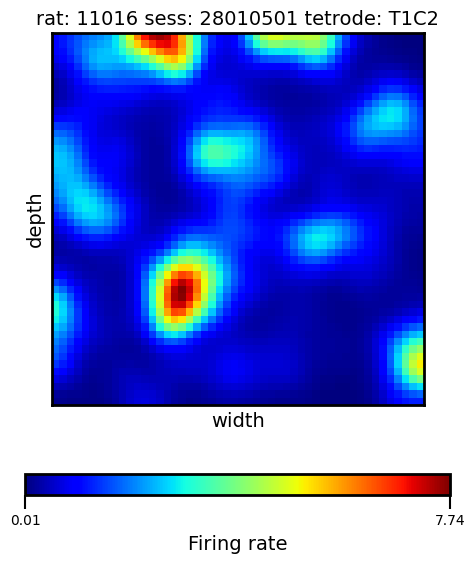

In [42]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
rate_map, x_bin, y_bin = sargolini_data.plot_recording_tetr(recording_index=2, ax=ax)

# Simulate trajectories and place cell activity
- Refactor the output so it doesn't have the extra dimensions
- Use more sequence steps so you keep track of the cells (batch size of 1)
- Color cell dots by position, then color their activity correspondingly

## Set variables for environment, animal trajectories and place cells

In [43]:
# Arena dimensions
room_width = 2.2
room_depth = 2.2

# We'll use a longer sequence just for plotting purposes
# Training will be done with short sequences
sequence_length = 300
batch_size = 4

# Place cells parameters
n_place_cells = 512
place_cell_rf = 0.12
surround_scale = 2.0
periodic = False
difference_of_gaussians = True

In [44]:
place_cells = PlaceCells(Np=n_place_cells, 
                         place_cell_rf=place_cell_rf,
                         surround_scale=surround_scale, 
                         room_width=room_width, 
                         room_depth=room_depth, 
                         periodic=periodic, 
                         DoG=difference_of_gaussians,
                         device=device)

The following trajectory generator is based on https://github.com/ganguli-lab/grid-pattern-formation/blob/master/trajectory_generator.py which implements https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002553

In [45]:
generator = TrajectoryGenerator(sequence_length, batch_size, room_width, room_depth, device, place_cells=place_cells)
traj = generator.generate_trajectory(room_width, room_depth, batch_size)
x, y = traj["target_x"], traj["target_y"]

In [46]:
x.shape, y.shape

((4, 300), (4, 300))

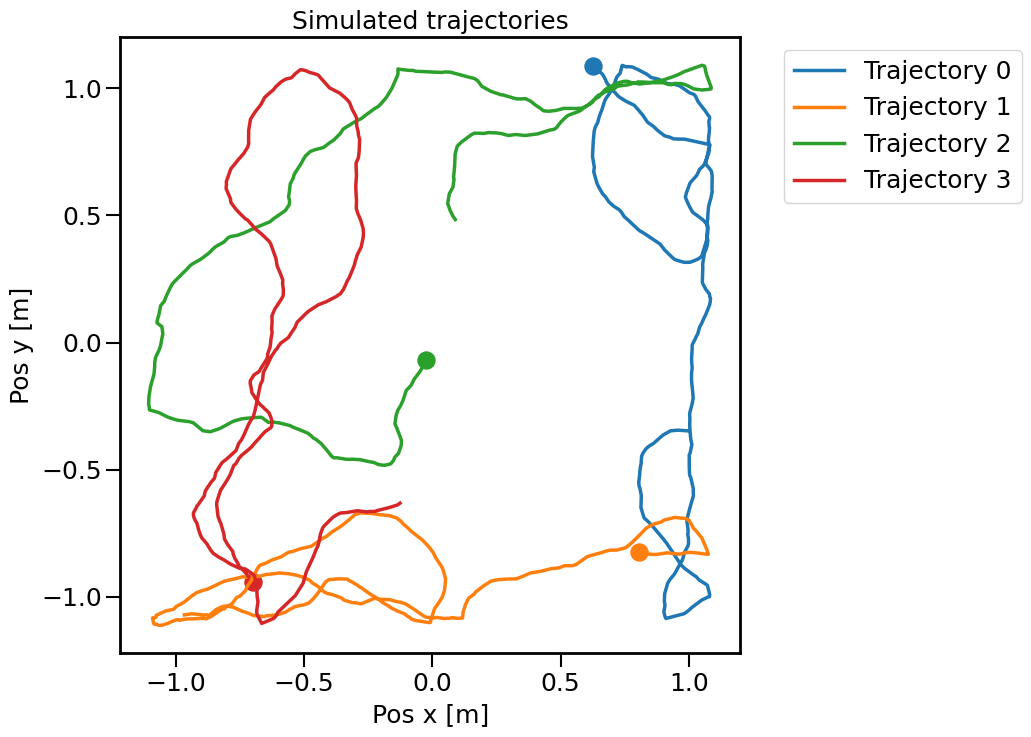

In [47]:
# Plotting options
plot_n_trajectories = batch_size
figure_size = (8, 8)
line_width = 2.5
marker_size = 150

# Plot trajectories
fig, ax = plt.subplots(1, 1, figsize=figure_size)
for i in range(plot_n_trajectories):
    init_x = traj["init_x"][i]
    init_y = traj["init_y"][i]
    ax.plot(x[i, :], y[i, :], label=f"Trajectory {i}", linewidth=line_width)
    ax.scatter(init_x, init_y, color=f"C{i}", marker="o", s=marker_size)
ax.set_xlabel("Pos x [m]")
ax.set_ylabel("Pos y [m]")
ax.set_title("Simulated trajectories")
# Putting the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [48]:
# Plot activity for one of the trajectories
trajectory_id = 2
trajectory = np.stack([x[trajectory_id, :], y[trajectory_id, :]], axis=1)

# Get place cell activity for each trajectory
pc_inputs, position, pc_outputs = generator.get_test_batch(traj=traj)
place_cells_positions = place_cells.get_place_cell_positions()
pc_rates_trajectories = pc_outputs[:, trajectory_id, :].detach().cpu().numpy().T

In [49]:
place_cells_positions.shape, pc_rates_trajectories.shape, trajectory.shape

((512, 2), (512, 300), (300, 2))

In [50]:
pc_outputs.shape, position.shape

(torch.Size([300, 4, 512]), torch.Size([300, 4, 2]))

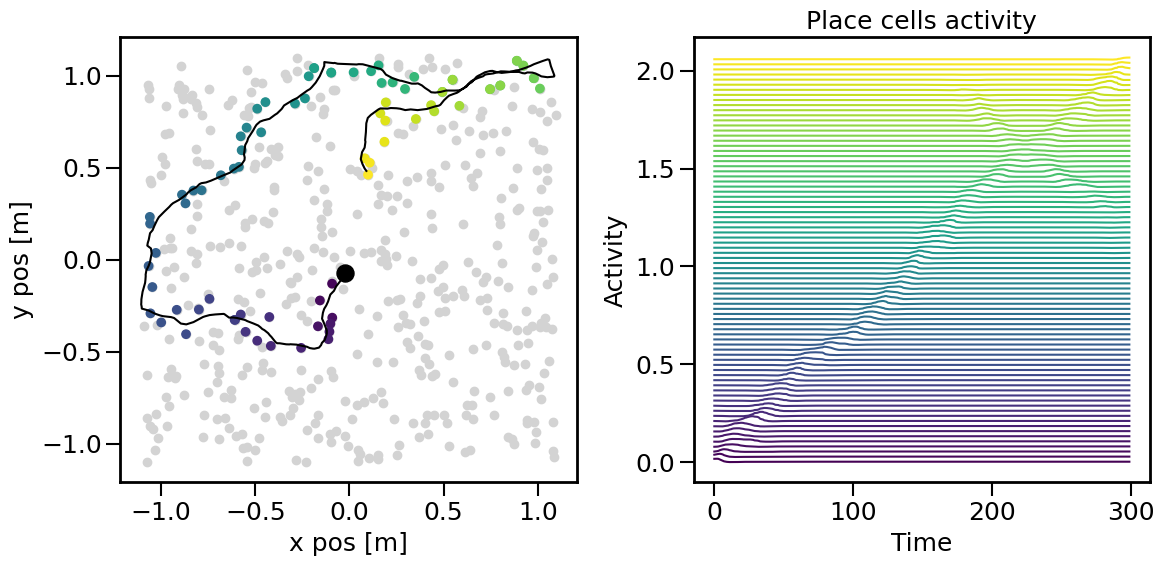

In [56]:
plot_n_cells = 100
raster = True  # Make raster-like plot
log_scale_activity = False

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = plot_trajectory_place_cells_activity(place_cells_center=place_cells_positions, 
                                                place_cell_activity=pc_rates_trajectories, 
                                                trajectory=trajectory, 
                                                ax1=ax1, 
                                                ax2=ax2, 
                                                plot_n_cells=plot_n_cells,
                                                log_scale=log_scale_activity,
                                                raster=raster)
plt.tight_layout()

# Show trajectory for different batches

In [52]:
# Now we try shorter sequences to train an RNN using backpropagation through time
# Training will be done with short sequences
sequence_length = 20
batch_size = 250

In [53]:
place_cells = PlaceCells(Np=n_place_cells, 
                         place_cell_rf=place_cell_rf,
                         surround_scale=surround_scale, 
                         room_width=room_width, 
                         room_depth=room_depth, 
                         periodic=periodic, 
                         DoG=difference_of_gaussians,
                         device=device)

generator = TrajectoryGenerator(sequence_length, batch_size, room_width, room_depth, device, place_cells=place_cells)
traj = generator.generate_trajectory(room_width, room_depth, batch_size)
x, y = traj["target_x"], traj["target_y"]

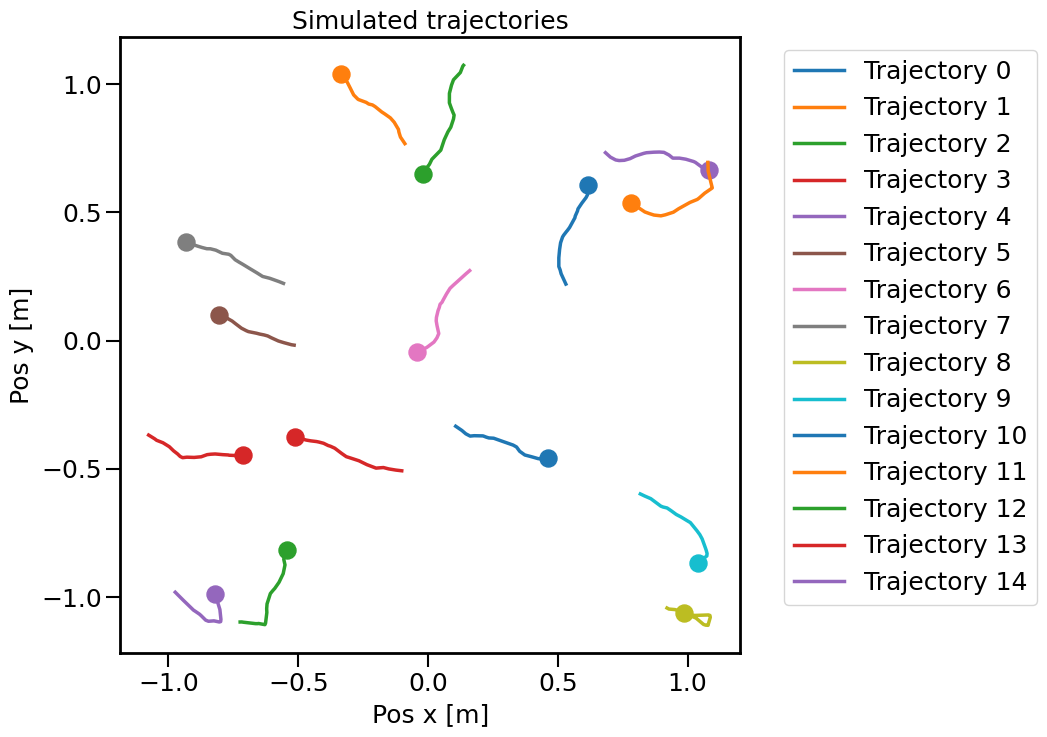

In [54]:
# Plotting options
plot_n_trajectories = 15
figure_size = (8, 8)
line_width = 2.5
marker_size = 150

# Plot trajectories
fig, ax = plt.subplots(1, 1, figsize=figure_size)
for i in range(plot_n_trajectories):
    init_x = traj["init_x"][i]
    init_y = traj["init_y"][i]
    ax.plot(x[i, :], y[i, :], label=f"Trajectory {i}", linewidth=line_width)
    ax.scatter(init_x, init_y, color=f"C{i}", marker="o", s=marker_size)
ax.set_xlabel("Pos x [m]")
ax.set_ylabel("Pos y [m]")
ax.set_title("Simulated trajectories")
# Putting the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Intro to RNNs
- Write equations for RNN
- Explain path integration problem
- Explain a bit of the idealized RNN
- Explain backpropagation through time

# Idealized RNN plot

# Initialize and train RNN
- Refactor RNN so it has some agent format
- Train RNN using default parameters and plot loss
- Creat a custom RNN class and override the forward function so users can test it
- Add pre-trained models in the cloud to play with

- Low dimensional population analysis to see torus (Fig 4 of https://www.cell.com/neuron/pdf/S0896-6273(22)00907-2.pdf) + relate to low dimensional of real grid cells (figure from https://www.nature.com/articles/s41586-021-04268-7) as well as low dim analysis of idealised path integration model
- Eigen vals of RNN conectivity matrix and relate to idealised attractor connectivity matrices ( (Fig 5 of https://www.cell.com/neuron/pdf/S0896-6273(22)00907-2.pdf)